In [18]:
%load_ext autoreload
# Always reload modules so that as you change code in src, it gets loaded
%autoreload 2
%matplotlib inline

import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import pandas as pd
import numpy as np
import random
import math
import EoN
import seaborn as sns
import time

# New Imports
#from ctrace.contact_tracing import *
#from ctrace.constraint import *
#from ctrace.solve import *
#from ctrace.simulation import *
#from ctrace.restricted import *
from ctrace.simulation import *
from ctrace.dataset import *
from ctrace.recommender import *
from ctrace.problem_label import *
from ctrace.utils import *
from ctrace.exec.param import GraphParam, SIRParam, FileParam, ParamBase, LambdaParam

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
graphs = {
    "montgomery": GraphParam('montgomery').data,
    "cville": GraphParam('cville').data
}

In [20]:
def segmented_run(run_id):
    in_data = pd.read_csv(PROJECT_ROOT / f'output/{run_id}/input.csv')
    out_data = pd.read_csv(PROJECT_ROOT / f'output/{run_id}/main.csv')
    df = pd.merge(in_data, out_data, how="left", on=["id"])

    # Rename the labels
    df['agent'] = df['agent'].replace({"segmented_greedy": "Segmented Degree"})
    df['graph'] = df['graph'].replace({'montgomery': "Montgomery", 'cville': "Albemarle"})
    
    return df

df_opt = segmented_run('run_aRkZx')

valid_caches = df_opt[df_opt['agent'] == 'MILP_fair'].dropna()['from_cache']
valid_df = df_opt[df_opt['from_cache'].isin(valid_caches)]
valid_df.head()

,id,graph,budget,agent,policy,transmission_rate,transmission_known,compliance_rate,compliance_known,discovery_rate,snitch_rate,from_cache,trial_id,seed,milp_obj
0,0,Montgomery,750,Segmented Degree,A,0.05,False,-1.0,False,1.0,1.0,mb20.json,0,15795,31.082312
1,1,Montgomery,750,Segmented Degree,A,0.05,False,-1.0,False,1.0,1.0,mo27.json,0,860,3.511424
2,2,Montgomery,750,Segmented Degree,A,0.05,False,-1.0,False,1.0,1.0,mg12.json,0,76820,266.996682
3,3,Montgomery,750,Segmented Degree,A,0.05,False,-1.0,False,1.0,1.0,ma14.json,0,54886,236.581790
4,4,Montgomery,750,Segmented Degree,A,0.05,False,-1.0,False,1.0,1.0,md15.json,0,6265,196.082908


In [21]:
valid_df

,id,graph,budget,agent,policy,transmission_rate,transmission_known,compliance_rate,compliance_known,discovery_rate,snitch_rate,from_cache,trial_id,seed,milp_obj
0,0,Montgomery,750,Segmented Degree,A,0.05,False,-1.0,False,1.0,1.0,mb20.json,0,15795,31.082312
1,1,Montgomery,750,Segmented Degree,A,0.05,False,-1.0,False,1.0,1.0,mo27.json,0,860,3.511424
2,2,Montgomery,750,Segmented Degree,A,0.05,False,-1.0,False,1.0,1.0,mg12.json,0,76820,266.996682
3,3,Montgomery,750,Segmented Degree,A,0.05,False,-1.0,False,1.0,1.0,ma14.json,0,54886,236.581790
4,4,Montgomery,750,Segmented Degree,A,0.05,False,-1.0,False,1.0,1.0,md15.json,0,6265,196.082908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3851,3851,Albemarle,1350,MILP_fair,A,0.05,False,-1.0,False,1.0,1.0,cm7.json,0,90102,541.047694
3852,3852,Albemarle,1350,MILP_fair,A,0.05,False,-1.0,False,1.0,1.0,cl16.json,0,51919,57.884799
3853,3853,Albemarle,1350,MILP_fair,A,0.05,False,-1.0,False,1.0,1.0,cd20.json,0,99441,7.232709
3854,3854,Albemarle,1350,MILP_fair,A,0.05,False,-1.0,False,1.0,1.0,cm19.json,0,27103,20.152037


In [ ]:
g = sns.catplot(x="budget", y="frac",
                hue="policy", col="agent", row="graph",
                data=result[result['policy'] != 'A_ONLY'], kind="bar",
                height=4, aspect=1,
                sharex=False,
                margin_titles=True);

(g.set_axis_labels("Budget", "Total Infected (%)"))
#     .set_titles("{row_name} {col_name}")
#     .despine(left=True))
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g._legend.set_title("Policy")

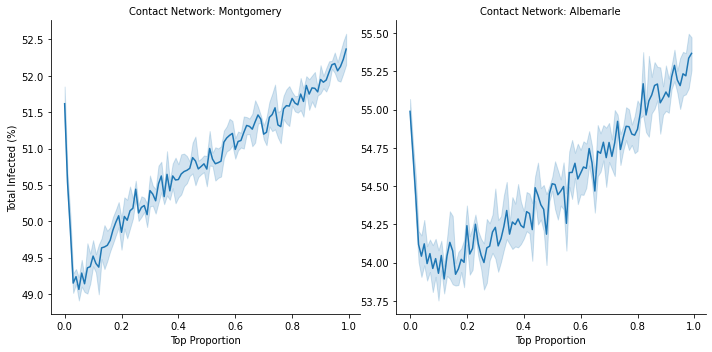

In [180]:
g = sns.relplot(
    x="split_top", 
    y="total_percent", 
    col="graph", 
    kind="line", 
    data=df_prop, 
    facet_kws={'sharey': False, 'sharex': True}
)

(g
  .set_axis_labels("Top Proportion", "Total Infected (%)")
  .set_titles("Contact Network: {col_name}")
  .tight_layout(w_pad=0)
)
g.savefig("combined_segmented_proportion")

In [190]:
def other_run(ignore_types=None):
    
    if ignore_types is None:
        ignore_types = ["EC", "DepRound Average", "DepRound Full", "DepRound Impoverished"]
    
    df = pd.read_csv(PROJECT_ROOT / "output" / "run_HHUqV" / "results.csv").replace({"DepRound_fair":"DepRound Full",
              "DegGreedy_fair":"DegGreedy Full"})
    df_avg = pd.read_csv(PROJECT_ROOT / "output" / "run_BxjJA" / "results.csv").replace({"DepRound_fair":"DepRound Average",
              "DegGreedy_fair":"DegGreedy Average", "DepRound_simplified":"DepRound Impoverished"})
    
    df_m = pd.read_csv(PROJECT_ROOT / "output" / "run_XK2Wx" / "results.csv").replace({"DepRound_fair":"DepRound Full",
          "DegGreedy_fair":"DegGreedy Full"})
    df_avg_m = pd.read_csv(PROJECT_ROOT / "output" / "run_kDUWp" / "results.csv").replace({"DepRound_fair":"DepRound Average",
              "DegGreedy_fair":"DegGreedy Average", "DepRound_simplified":"DepRound Impoverished"})

    df = pd.concat([df, df_avg, df_m, df_avg_m])
    
    
    df = df[~df["agent"].isin(ignore_types)]
    
    
#     df["infection_list"] = df["infections_step"].apply(lambda x: [int(i) for i in x.strip("[]").split(", ")])
#     df["time_steps"] = df["infection_list"].apply(lambda x: len(x))
#     df["time_step_peak"] = df["infection_list"].apply(lambda x: x.index(max(x)))
#     df["peak_count"] = df["infection_list"].apply(lambda x: max(x))
#     df["peak_percent"] = df.apply(lambda x: 100.0*x["peak_count"]/size(x["G"]), axis = 1)

    def size(name: str):
        if name[0] == "c": return 131219
        else: return 75457
    
    
    df["total_percent"] = df.apply(lambda x: 100.0*x["infection_count"]/size(x["G"]), axis = 1)

    # Rename
    df = df.rename(columns={"G":"graph",})
    df['graph'] = df['graph'].replace({'montgomery': "Montgomery", 'cville': "Albemarle"})
    return df


df_other = other_run()
df_other.head()

df_other[df_other['graph'] == 'Montgomery']

,graph,budget,policy,transmission_rate,transmission_known,compliance_rate,compliance_known,discovery_rate,snitch_rate,from_cache,agent,trial_id,infection_count,infections_step,total_percent
0,Montgomery,400,none,0.05,True,0.8,True,1,1,c7.json,DegGreedy Full,2,38138,"[0, 10, 7, 12, 20, 52, 80, 160, 269, 448, 627,...",50.542693
1,Montgomery,400,none,0.05,True,0.8,True,1,1,c7.json,DegGreedy Full,1,37762,"[0, 10, 7, 12, 20, 52, 80, 160, 269, 485, 634,...",50.044396
2,Montgomery,400,none,0.05,True,0.8,True,1,1,c7.json,DegGreedy Full,3,38248,"[0, 10, 7, 12, 20, 52, 80, 160, 269, 513, 713,...",50.688472
3,Montgomery,400,none,0.05,True,0.8,True,1,1,c7.json,DegGreedy Full,6,37885,"[0, 10, 7, 12, 20, 52, 80, 160, 269, 424, 631,...",50.207403
4,Montgomery,400,none,0.05,True,0.8,True,1,1,c7.json,DegGreedy Full,4,38263,"[0, 10, 7, 12, 20, 52, 80, 160, 269, 456, 648,...",50.708350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3405,Montgomery,1250,none,0.05,False,0.8,False,1,1,c7.json,Degree,5,32370,"[0, 10, 7, 12, 20, 52, 80, 160, 269, 488, 505,...",42.898605
3406,Montgomery,1250,none,0.05,False,0.8,False,1,1,c7.json,Degree,6,32331,"[0, 10, 7, 12, 20, 52, 80, 160, 269, 466, 526,...",42.846919
3407,Montgomery,1250,none,0.05,False,0.8,False,1,1,c7.json,Degree,7,32333,"[0, 10, 7, 12, 20, 52, 80, 160, 269, 476, 520,...",42.849570
3408,Montgomery,1250,none,0.05,False,0.8,False,1,1,c7.json,Degree,9,32805,"[0, 10, 7, 12, 20, 52, 80, 160, 269, 481, 505,...",43.475092


In [191]:

df_budgets['split_top'].value_counts()

0.0    245
0.1    245
0.9    245
0.3    245
0.8    245
0.2    245
1.0    245
0.4    245
0.6    245
0.5    245
0.7    245
Name: split_top, dtype: int64

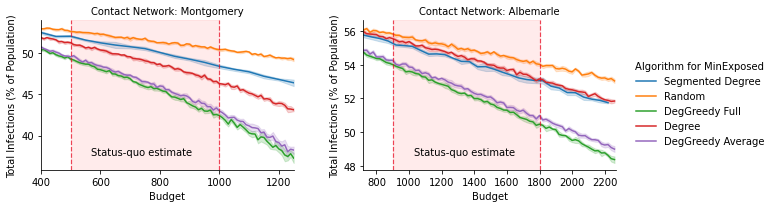

In [192]:
from tqdm import tqdm



df = pd.concat([df_budgets[df_budgets['split_top'] == 0.3], df_other])
graph_data = {
    'Albemarle': {
        'min_left': 720,
        'left': 900,
        'right': 1800,
        'max_right': 2270,
        'middle': 1350,
        'size': 131219,
    },
    'Montgomery': {
        'min_left': 400,
        'left' : 500,
        'right' : 1000,
        'max_right' : 1250,
        'middle' : 750,
        'size': 75457,
    }
}

# Assumes Dataframe with the following properties:
g = sns.relplot(
    x="budget", 
    y="total_percent", 
    hue='agent',
    col="graph", 
    kind="line", 
    data=df, 
    facet_kws={'sharey': False, 'sharex': False},
    height=3, aspect=1.5
)

(g.set_axis_labels("Top Proportion", "Total Infected (%)")
    .set_titles("Contact Network: {col_name}")
    .tight_layout(w_pad=5)
)    

for (col_val), ax in g.axes_dict.items():
    data = graph_data[col_val]
    ax.set_xlabel("Budget")
    ax.set_ylabel("Total Infections (% of Population)")
    ax.axvline(x=data['left'], linewidth=1.2, color=(0.9,0,0.1, 0.7),linestyle='--')
    ax.axvline(x=data['right'], linewidth=1.2, color=(0.9,0,0.1, 0.7),linestyle='--')
    ax.text(.2, .1, f"Status-quo estimate", fontsize=10, transform=ax.transAxes)

    ax.axvspan(data['left'], data['right'], alpha=0.08, color='red')
    ax.set_xlim(data['min_left'], data['max_right'])

g.legend.set_title('Algorithm for MinExposed')
g.savefig(f"figs/combined_segmented_budget_{i}")

# g.fig.legend(
#     ['Random Isolation','Eigenvector Centrality','DepRound','DegGreedy','No Intervention'],
#     title='Algorithm for MinExposed',
#     loc = "lower center", 
#     ncol = 5, 
#     bbox_to_anchor = (0.4, -0.2), 
#     prop={'size':10}
# )

# g.add_legend(
#     title='Algorithm for MinExposed',
#     loc = "lower center", 
#     ncol = 5, 
#     bbox_to_anchor = (0.4, -0.2), 
#     prop={'size':10}
# )




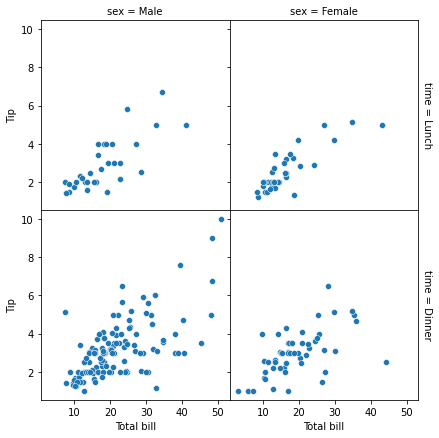

In [160]:
tips = sns.load_dataset("tips")
g = sns.FacetGrid(tips, col="sex", row="time", margin_titles=True, despine=False)
g.map_dataframe(sns.scatterplot, x="total_bill", y="tip")
g.set_axis_labels("Total bill", "Tip")
g.fig.subplots_adjust(wspace=0, hspace=0)

